# Построение базовой модели рекомендательной системы

In [1]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
import pickle
import random
import math


## Подготовка данных

In [2]:
random.seed(3214)

загружаем датасет и словарь с мета-информацией

In [3]:
with open('../data/pickles/main_dict.pickle', 'rb') as f:
    main_dict = pickle.load(f)

In [4]:
df = pd.read_csv('../data/csv/merge_df.csv', index_col=0)
df.head()

,track,1_mfcc_1,1_mfcc_2,1_mfcc_3,1_mfcc_4,1_mfcc_5,1_mfcc_6,1_mfcc_7,1_mfcc_8,1_mfcc_9,...,all_ss_min,all_ss_std,all_sf_max,all_sf_mean,all_sf_min,all_sf_std,all_zcr_max,all_zcr_mean,all_zcr_min,all_zcr_std
0,061010.mp3,-724.060181,174.672104,-22.694757,5.049683,-10.285789,-7.565227,-17.961994,-1.329323,-13.898221,...,0.737701,0.991601,0.240276,0.041676,0.008984,0.031454,0.108398,0.029397,0.009277,0.014918
1,061172.mp3,-692.448303,117.801537,18.185888,5.736947,5.938968,31.851004,1.060427,4.214683,-0.146251,...,-0.198049,0.948205,0.390652,0.080923,0.000357,0.059621,0.351562,0.068662,0.002930,0.058827
2,061589.mp3,-697.955811,112.710243,80.530632,18.408318,16.321367,33.912514,-1.067550,19.436161,2.497976,...,-0.194649,0.554220,0.488206,0.133584,0.017999,0.079505,0.125000,0.028202,0.000977,0.020876
3,061493.mp3,-630.083130,135.834732,-17.474176,36.666378,20.877747,3.231712,0.163455,-4.143034,-7.589878,...,0.461225,0.344698,0.404520,0.101769,0.022331,0.065322,0.267090,0.083095,0.006348,0.036801
4,061492.mp3,-692.294617,154.660141,-3.271099,31.385326,22.588284,4.178376,-0.790970,-4.321088,-4.325193,...,0.710971,0.538033,0.420857,0.083492,0.010698,0.055768,0.450195,0.098991,0.005859,0.067057


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7982 entries, 0 to 7981
Columns: 338 entries, track to all_zcr_std
dtypes: float64(336), int64(1), object(1)
memory usage: 20.6+ MB


Отбираем 100 треков для тестовой выборки. Каждый трек должен содержать как минимум 10 тегов.

In [6]:
test_idx = list()
while len(test_idx) < 100:
    idx = random.randint(0, df.shape[0] - 1)
    if idx in test_idx:
        continue
    track_id = int(df.loc[idx].track[:-4])
    tags = main_dict[track_id]['all_tags']
    if len(tags) >= 10:
        test_idx.append(idx)

In [7]:
df_test = df.loc[test_idx]
df_test

,track,1_mfcc_1,1_mfcc_2,1_mfcc_3,1_mfcc_4,1_mfcc_5,1_mfcc_6,1_mfcc_7,1_mfcc_8,1_mfcc_9,...,all_ss_min,all_ss_std,all_sf_max,all_sf_mean,all_sf_min,all_sf_std,all_zcr_max,all_zcr_mean,all_zcr_min,all_zcr_std
7301,010673.mp3,-626.681091,132.151154,11.753740,45.711430,-0.209040,10.068515,-0.682384,5.395576,-4.435939,...,0.461337,0.281160,0.329500,0.124018,0.027167,0.045374,0.130859,0.031217,0.003418,0.019365
3931,066643.mp3,-687.945374,141.427277,-16.972485,19.092112,6.906140,3.117708,6.967309,-2.045398,-7.208217,...,-0.111801,0.627290,0.380662,0.080697,0.000165,0.061523,0.282227,0.049509,0.002930,0.025951
5176,000194.mp3,-782.241943,178.044266,-29.330959,18.219608,-14.123279,-10.458302,-16.387886,-5.279102,-16.686710,...,0.276664,0.634153,0.264619,0.043619,0.000129,0.038136,0.169922,0.037896,0.001953,0.017058
80,074421.mp3,-623.853394,122.672737,17.257471,4.505549,0.719744,-2.922961,-5.741470,-1.727011,-18.558123,...,0.421106,0.539590,0.264868,0.082399,0.007031,0.040712,0.224121,0.051835,0.009277,0.032241
7903,131553.mp3,-645.512512,74.718880,12.483846,45.145756,38.911320,16.187067,6.199753,0.013115,-3.431449,...,0.100123,0.391042,0.335317,0.112432,0.000625,0.050604,0.271973,0.079668,0.008789,0.049538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3341,075436.mp3,-800.051819,241.068558,40.636051,-0.057632,6.397528,-18.648108,-1.818632,3.204657,-0.186070,...,0.923011,1.546881,1.210505,0.112725,0.010022,0.145565,0.138184,0.015291,0.000488,0.012997
4878,063655.mp3,-758.179688,233.961899,28.287888,11.515189,6.204473,16.416714,-10.615239,0.827990,5.827968,...,1.715050,0.839399,1.088153,0.082296,0.024415,0.079127,0.032227,0.012229,0.000488,0.004685
5520,053301.mp3,-650.022522,133.733185,7.322467,12.278226,36.223629,19.627594,21.320019,11.456765,6.618299,...,0.419925,0.407566,0.518842,0.109679,0.016570,0.091477,0.231445,0.044514,0.002930,0.038336
3641,062526.mp3,-666.008362,121.186523,6.822075,42.061932,-10.464552,14.471254,7.220425,5.017753,-1.855397,...,0.230255,0.614144,0.625459,0.092227,0.006027,0.086389,0.187500,0.035097,0.001953,0.022623


In [8]:
df_train = df.loc[list(set(df.index.values) - set(test_idx))]
df_train

,track,1_mfcc_1,1_mfcc_2,1_mfcc_3,1_mfcc_4,1_mfcc_5,1_mfcc_6,1_mfcc_7,1_mfcc_8,1_mfcc_9,...,all_ss_min,all_ss_std,all_sf_max,all_sf_mean,all_sf_min,all_sf_std,all_zcr_max,all_zcr_mean,all_zcr_min,all_zcr_std
0,061010.mp3,-724.060181,174.672104,-22.694757,5.049683,-10.285789,-7.565227,-17.961994,-1.329323,-13.898221,...,0.737701,0.991601,0.240276,0.041676,8.983906e-03,0.031454,0.108398,0.029397,0.009277,0.014918
2,061589.mp3,-697.955811,112.710243,80.530632,18.408318,16.321367,33.912514,-1.067550,19.436161,2.497976,...,-0.194649,0.554220,0.488206,0.133584,1.799921e-02,0.079505,0.125000,0.028202,0.000977,0.020876
3,061493.mp3,-630.083130,135.834732,-17.474176,36.666378,20.877747,3.231712,0.163455,-4.143034,-7.589878,...,0.461225,0.344698,0.404520,0.101769,2.233087e-02,0.065322,0.267090,0.083095,0.006348,0.036801
4,061492.mp3,-692.294617,154.660141,-3.271099,31.385326,22.588284,4.178376,-0.790970,-4.321088,-4.325193,...,0.710971,0.538033,0.420857,0.083492,1.069842e-02,0.055768,0.450195,0.098991,0.005859,0.067057
5,061592.mp3,-708.504639,136.741913,9.762825,40.804737,17.343578,28.947464,15.307942,17.034895,9.786160,...,-0.039187,0.629073,0.458335,0.132431,6.568079e-11,0.090427,0.515137,0.018989,0.002441,0.039541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7977,131914.mp3,-654.926941,144.197983,-5.618096,12.815182,-4.743158,4.794647,-0.457318,2.406655,-8.439367,...,0.907090,0.585478,0.172700,0.063363,1.671647e-02,0.027547,0.136230,0.058892,0.012207,0.026086
7978,131772.mp3,-625.237183,158.683304,-10.997794,23.054964,11.636267,-1.839731,-17.972336,-9.967291,-12.986640,...,0.608825,0.747877,0.245719,0.111260,6.102545e-03,0.040364,0.070312,0.020365,0.005859,0.009048
7979,131792.mp3,-655.022644,144.006958,5.970843,14.379925,14.236056,3.561646,-4.041969,-4.800819,-3.666181,...,0.740162,0.707120,0.290256,0.078840,7.514172e-03,0.051776,0.104980,0.032318,0.000488,0.014633
7980,131624.mp3,-788.494507,75.723251,35.248608,28.392780,4.289547,18.946749,-5.460835,10.575089,-8.978883,...,0.130618,0.542250,0.212018,0.045943,9.695412e-04,0.043634,0.321289,0.102740,0.007812,0.053932


In [9]:
df_test[df_test['track'] == '075752.mp3']

,track,1_mfcc_1,1_mfcc_2,1_mfcc_3,1_mfcc_4,1_mfcc_5,1_mfcc_6,1_mfcc_7,1_mfcc_8,1_mfcc_9,...,all_ss_min,all_ss_std,all_sf_max,all_sf_mean,all_sf_min,all_sf_std,all_zcr_max,all_zcr_mean,all_zcr_min,all_zcr_std
3293,075752.mp3,-668.406067,129.446136,22.64468,29.89543,14.913042,6.827713,5.490972,3.777357,-0.879182,...,-0.10582,0.774325,0.377023,0.107714,0.014806,0.063929,0.263184,0.038428,0.002441,0.029472


In [10]:
df_train.to_csv('../data/csv/train.csv')
df_test.to_csv('../data/csv/test.csv')

## Визуализация данных

In [11]:
features_train = df_train.drop(['track'], 1)
features_test = df_test.drop(['track'], 1)

In [12]:
scaler = StandardScaler()
scaler.fit(features_train)
X_train = scaler.transform(features_train)
X_test = scaler.transform(features_test)

In [13]:
pca_viz = PCA(n_components=2)
pca_viz.fit(X_train)
X_train_viz = pca_viz.transform(X_train)
X_test_viz = pca_viz.transform(X_test)

In [14]:
pca_viz.explained_variance_ratio_

array([0.25335772, 0.13107885])

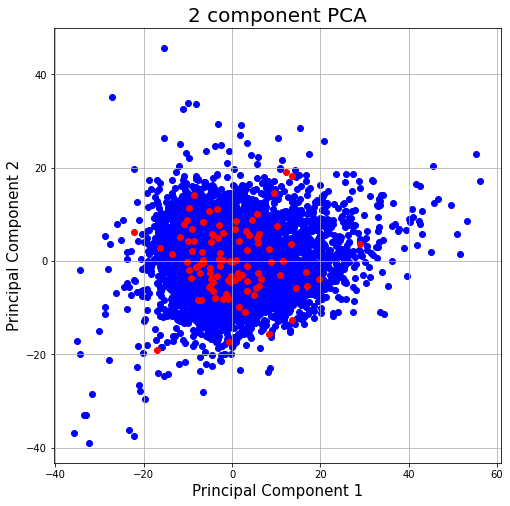

In [15]:
fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(X_train_viz[:, 0], X_train_viz[:, 1], c='b')
ax.scatter(X_test_viz[:, 0], X_test_viz[:, 1], c='r')
ax.grid()

In [16]:
pca_viz_3 = PCA(n_components=3)
pca_viz_3.fit(X_train)
X_train_viz = pca_viz_3.transform(X_train)
X_test_viz = pca_viz_3.transform(X_test)

In [17]:
pca_viz_3.explained_variance_ratio_

array([0.25335772, 0.13107885, 0.097319  ])

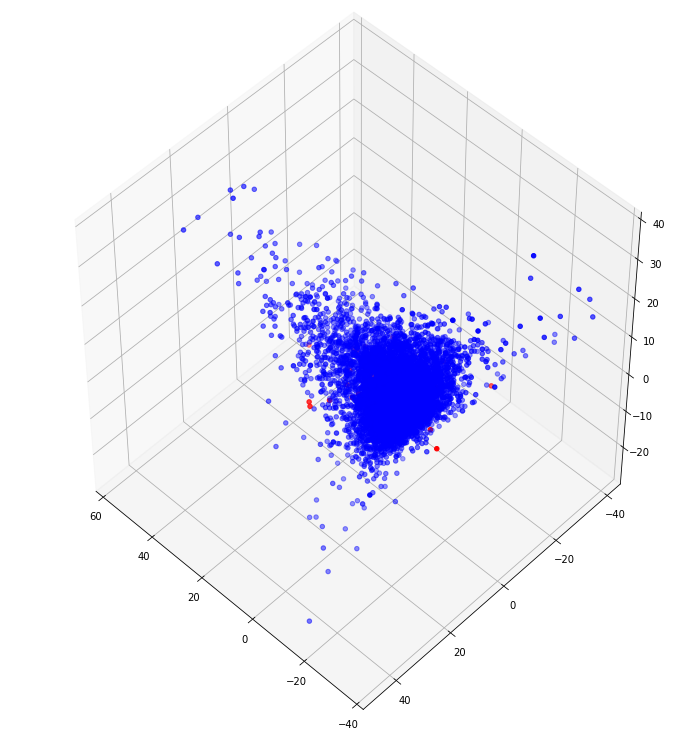

In [18]:
fig = plt.figure(1, figsize=(10, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X_test_viz[:, 0], X_test_viz[:, 1], X_test[:, 2], c='r')
ax.scatter(X_train_viz[:, 0], X_train_viz[:, 1], X_train_viz[:, 2], c='b')


## Формирование векторного пространства

Уменьшим размерность векторов треков методом главных компонент

In [19]:
pca = PCA(0.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [20]:
X_train.shape

(7882, 103)

In [21]:
X_test.shape

(100, 103)

In [22]:
pca.explained_variance_ratio_

array([0.25335772, 0.13107885, 0.097319  , 0.0623545 , 0.0309936 ,
       0.03003364, 0.02229566, 0.01795163, 0.01577264, 0.01408451,
       0.01340284, 0.01194961, 0.01121986, 0.00988471, 0.00972236,
       0.00921648, 0.00883436, 0.00831201, 0.00808025, 0.00772712,
       0.00760734, 0.00711579, 0.00680957, 0.00650093, 0.00571318,
       0.00528451, 0.00497399, 0.0046293 , 0.0044177 , 0.00421929,
       0.00413324, 0.00386121, 0.00365366, 0.00339282, 0.00331311,
       0.00311343, 0.00305891, 0.00297801, 0.00273579, 0.00270868,
       0.00260579, 0.00255611, 0.00251641, 0.00245585, 0.00233522,
       0.00229095, 0.00223837, 0.00217337, 0.00210012, 0.00202731,
       0.00186905, 0.00184666, 0.00183642, 0.00180138, 0.00171459,
       0.0016737 , 0.00166407, 0.00164122, 0.00158054, 0.00152881,
       0.00151461, 0.00145748, 0.00143763, 0.00142148, 0.00138667,
       0.00137382, 0.00134648, 0.0013226 , 0.00130715, 0.0012876 ,
       0.00124801, 0.00123405, 0.0012168 , 0.00118834, 0.00114

Оценим Евклидово расстояние между треками

In [23]:
neigh = NearestNeighbors(10)
neigh.fit(X_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

## Построение рекомендаций и их оценка

В качестве рекомендаций будем использовать 10 ближайших соседей к вектору тестового трека. Для каждой рекомендации будем сравнивать теги с тегами "запроса". Для количественной оценки сходства множества тегов используем f-меру. Если она выше парогового значения, то считаем рекомендацию релевантной. Для количественной оценки релевантности рекомендаций используем prcision@10.Для оценки ранжирования применим nDCG. Для общей оценки рекомендательной системы усредним метрики по всем тестовым запросам.

In [24]:
def count_good_recommend(query_idx, answer_list, trhold):
    counter = 0
    query_id = int(df_test.iloc[query_idx].track[:-4])
    relevant = [query_id]
    query_tags = main_dict[query_id]['all_tags']
    for idx in answer_list:
        answer_id = int(df_train.iloc[idx].track[:-4])
        answer_tags = main_dict[answer_id]['all_tags']
        score = 0
        i = 0
        for tag in answer_tags:
            if tag in query_tags:
                i += 1
        if i == 0:
            continue
        
        precision = i / len(answer_tags)
        recall = i / len(query_tags)
        score = 2 * precision * recall / (precision + recall)
        if score >= trhold:        
            counter += 1
            relevant.append(answer_id)
    return counter, relevant

In [25]:
def count_ndcg(neighbors, relevant_list):
    dcg = 0
    idcg = 0
    for i in range(len(neighbors)):
        track = int(df_train.iloc[neighbors[i]].track[:-4])
        if track in relevant_list:
            dcg += 1 / math.log(i + 2, 2)
        idcg += 1 / math.log(i + 2, 2)
    ndcg = dcg / idcg
    return ndcg

In [29]:
mean_ap = 0
ndcg = 0
for i in range(100):
    neighbors = neigh.kneighbors([X_test[i]])[1][0]
    relevant_num, relevant_list = count_good_recommend(i, neighbors, trhold=0.3)
#     print(relevant_list)
    print(relevant_list[0], [df_train.iloc[x].track[:-4] for x in neighbors])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(neighbors, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100

10673 ['030682', '036481', '028480', '141874', '062586', '111378', '047194', '107954', '091851', '106456']
66643 ['091468', '142575', '072050', '081084', '106948', '122087', '129395', '133798', '138041', '108460']
194 ['006331', '038779', '000211', '004234', '006379', '043590', '012481', '038782', '113696', '000210']
74421 ['148214', '020704', '085490', '064247', '091170', '004076', '134928', '125194', '064590', '072058']
131553 ['123835', '126104', '042475', '029961', '052645', '129046', '108809', '126295', '099260', '064522']
24431 ['024422', '066638', '036987', '024425', '052141', '114037', '114042', '036994', '051260', '056804']
144469 ['091934', '095726', '136995', '095724', '106564', '122079', '127037', '122365', '122646', '067330']
87100 ['087106', '144476', '139638', '093917', '087098', '133975', '019417', '010439', '018607', '073573']
69204 ['006439', '144212', '150078', '035549', '123645', '031165', '028546', '085318', '055237', '122808']
27454 ['026655', '122683', '124891', 

5264 ['073770', '121590', '075427', '127203', '142949', '109357', '067366', '126670', '053937', '138041']
19759 ['081083', '134934', '134937', '106948', '019758', '143221', '117666', '125187', '081085', '064590']
41568 ['122936', '081543', '127289', '054235', '121734', '081613', '125195', '106339', '096696', '097590']
24429 ['110690', '146019', '097960', '119545', '116547', '113789', '069784', '025804', '052449', '109976']
86788 ['111306', '147412', '096401', '099345', '087153', '083790', '096399', '087152', '087490', '107101']
152418 ['093986', '127559', '060547', '122398', '004836', '038776', '038784', '024702', '140043', '010678']
64630 ['071690', '112484', '040845', '130650', '130170', '060472', '026034', '126103', '138578', '143290']
85832 ['004522', '124891', '093363', '075442', '131938', '073342', '026655', '085308', '073561', '122354']
75317 ['071253', '071244', '071248', '075379', '075376', '083717', '108491', '089447', '067121', '071249']
21401 ['013930', '121590', '046159', 

In [30]:
mean_ap

0.14799999999999996

In [31]:
mean_ndcg

0.16374159740444388

# Черновик

In [234]:
answers = neigh.kneighbors([X_test[42]])[1][0]
answers

array([2842, 5045, 3408, 3140, 2073, 2006, 1599, 5981, 5520, 1297])

In [235]:
query_id = int(df_test.iloc[42].track[:-4])

In [236]:
query = main_dict[query_id]['all_tags']
query

['punk',
 'reggae - dub',
 'electronic',
 'love',
 'international',
 'business of panic',
 'stop that mission',
 'all the stars',
 'reggae',
 'all back to mine',
 'world',
 'dub']

In [237]:
answer_id = int(df_train.iloc[2842].track[:-4])

In [238]:
answer = main_dict[answer_id]['all_tags']
answer

['female vocalists',
 'alternative',
 'electronic',
 'mgee',
 'chillout',
 'indie',
 'synth pop',
 'downtempo',
 'electropop',
 'indie pop',
 'maine',
 'under 2000 listeners',
 'pop',
 'swedish']

In [220]:
j = 1
for some in answer:
    if some in query:
        j += 1
aprecision = j / len(answer)
arecall = j / len(query)
b = 1
f1 = 2 * aprecision * arecall / (aprecision + arecall)
print(aprecision, arecall, f1)

1.0 0.2 0.33333333333333337


In [96]:
count_good_recommend(11, answers, 0.3)

10

In [215]:
df_test.iloc[5].track[:-4]

'024431'

In [200]:
df_train.iloc[4254].track[:-4]

'142079'

In [55]:
i

0

In [42]:
len(main_dict.keys())

7324

In [98]:
"AAAA BBB".lower()

'aaaa bbb'

In [53]:
with open('../data/pickles/main_dict.pickle', 'rb') as f:
    main_dict = pickle.load(f)

In [111]:
with open('../data/pickles/main_dict.pickle', 'wb') as f:
    pickle.dump(main_dict, f)